# 식품 배송 데이터 분석

## 구매자 분석

### 1. 10분위 분석

* 고객별로 주문 건수를 구한 뒤, 주문 건수를 기준으로 각 고객이 어떤 그룹에 속하는지 구한다.
* 다음으로 각 분위 위수별 주문 건수의 합을 구하면, 전체 주문 건이 어떤 그룹에 얼마나 집중되어 있는지 계산할 수 있다.

### 10분위 분석
* 전체를 10분위로 나누어 각 분위수에 해당하는 집단의 성질을 나타내는 방법
* 10분위 분석을 진행하려면 먼저 각 구매자의 분위 수를 구해야 한다. 여기선 고객들의 주문 건수를 기준으로 분위 수를 나눈다.

* 주문 건수에 따른 Rank 생성

In [ ]:
# 주문 건수에 따른 Rank 생성
SELECT *,
ROW_NUMBER() OVER(ORDER BY F DESC) RNK
FROM
(SELECT user_id, COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1) A

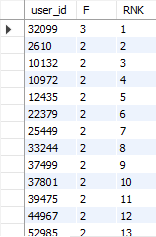

* 고객별로 분위 수를 매기려면 전체 고객이 몇 명인지 알아야 한다. 다음과 같은 방법으로 전체 고객 수를 계산한다.

In [ ]:
# 전체 고객 수 계산
SELECT COUNT(DISTINCT user_id)
FROM
(SELECT user_id,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY
1) A;

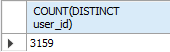

* 각 등수에 따른 분위 수는 CASE WHEN 구문을 이용해 다음과 같은 방법으로 설정할 수 있다.

In [ ]:
# 각 등수에 따른 분위수1
SELECT *,
CASE WHEN RNK BETWEEN 1 AND 316 THEN 'Quantile 1'
WHEN RNK BETWEEN 317 AND 632 THEN 'Quantile 2'
WHEN RNK BETWEEN 633 AND 948 THEN 'Quantile 3'
WHEN RNK BETWEEN 949 AND 1264 THEN 'Quantile 4'
WHEN RNK BETWEEN 1265 AND 1580 THEN 'Quantile 5'
WHEN RNK BETWEEN 1581 AND 1895 THEN 'Quantile 6'
WHEN RNK BETWEEN 1896 AND 2211 THEN 'Quantile 7'
WHEN RNK BETWEEN 2212 AND 2527 THEN 'Quantile 8'
WHEN RNK BETWEEN 2528 AND 2843 THEN 'Quantile 9'
WHEN RNK BETWEEN 2844 AND 3159 THEN 'Quantile 10' END quantile
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY F DESC) RNK
FROM
(SELECT user_id,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1) A) A;

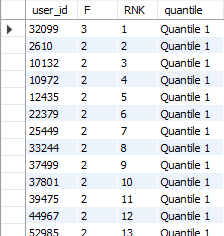

* 모든 등수를 기재할 필요 없이 다음과 같은 방법으로도 처리 가능하다.

In [ ]:
# 각 등수에 따른 분위수2
SELECT *,
CASE WHEN RNK <= 316 THEN 'Quantile 1'
WHEN RNK <= 632 THEN 'Quantile 2'
WHEN RNK <= 948 THEN 'Quantile 3'
WHEN RNK <= 1264 THEN 'Quantile 4'
WHEN RNK <= 1580 THEN 'Quantile 5'
WHEN RNK <= 1895 THEN 'Quantile 6'
WHEN RNK <= 2211 THEN 'Quantile 7'
WHEN RNK <= 2527 THEN 'Quantile 8'
WHEN RNK <= 2843 THEN 'Quantile 9'
WHEN RNK <= 3159 THEN 'Quantile 10' END quantile
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY F DESC) RNK
FROM
(SELECT user_id,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1) A) A;

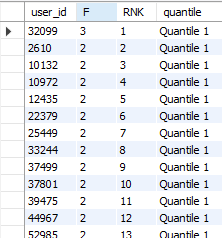

* 각 분위 수별 특성을 파악해 보고자 한다.
* 각 분위수별 평균 Recency를 파악하기 위해 먼저 위의 조회 결과를 하나의 테이블로 생성해 user_id별 분위 수 정보를 생성한다.

In [ ]:
# 하나의 테이블로 생성해 user_id별 분위 수 정보 생성
CREATE TEMPORARY TABLE user_quantile AS
SELECT *,
CASE WHEN RNK BETWEEN 1 AND 316 THEN 'Quantile 1'
WHEN RNK BETWEEN 317 AND 632 THEN 'Quantile 2'
WHEN RNK BETWEEN 633 AND 948 THEN 'Quantile 3'
WHEN RNK BETWEEN 949 AND 1264 THEN 'Quantile 4'
WHEN RNK BETWEEN 1265 AND 1580 THEN 'Quantile 5'
WHEN RNK BETWEEN 1581 AND 1895 THEN 'Quantile 6'
WHEN RNK BETWEEN 1896 AND 2211 THEN 'Quantile 7'
WHEN RNK BETWEEN 2212 AND 2527 THEN 'Quantile 8'
WHEN RNK BETWEEN 2528 AND 2843 THEN 'Quantile 9'
WHEN RNK BETWEEN 2844 AND 3159 THEN 'Quantile 10' END quantile
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY F DESC) RNK
FROM
(SELECT user_id,
COUNT(DISTINCT order_id) F
FROM orders
GROUP BY 1) A) A;

* 다음의 방법으로 각 분위 수별 전체 주문 건수의 합을 구할 수 있다.

In [ ]:
# 각 분위 수별 전체 주문 건수의 합 구하기
SELECT quantile, SUM(F) F
FROM user_quantile
GROUP BY 1;

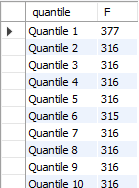

* 전체 주문 건수를 계산하고, 각 분위 수의 주문 건수를 전체 주문 건수로 나누어 보고자 한다.

In [ ]:
# 전체 주문 건수를 계산
SELECT SUM(F) FROM user_quantile;

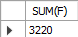

In [ ]:
# 각 분위 수의 주문 건수를 전체 주문 건수로 나누기
SELECT quantile, SUM(F)/3220 F
FROM user_quantile
GROUP BY 1;

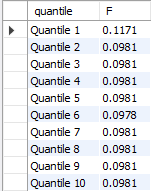

## 상품 분석

* 각 상품의 판매 특성에 대해 알아보기 위해 먼저 재구매 비중이 높은 상품을 찾아본다.
* 상품별 재구매 비중과 주문 건수를 계산한다.

In [ ]:
# 상품별 재구매 비중과 주문 건수 계산
SELECT product_id, SUM(reordered)/SUM(1) Reorder_Rate,
COUNT(DISTINCT order_id) F
FROM order_products__prior
GROUP BY product_id
ORDER BY Reorder_Rate DESC;

* 주문 건수가 일정 건수 이하인 상품은 제외하고 보고자 한다.
* HAVING을 이용하여 일정 건수 이하인 상품들을 쉽게 제외할 수 있다.

In [ ]:
# HAVING을 이용하여 일정 건수 이하인 상품들 제외
SELECT A.product_id, SUM(reordered)/SUM(1) Reorder_Rate,
COUNT(DISTINCT order_id) F
FROM order_products__prior A
LEFT JOIN products B
ON A.product_id = B.product_id
GROUP BY product_id
HAVING COUNT(DISTINCT order_id) > 10;

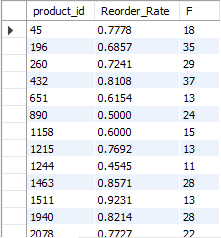

### HAVING vs WHERE
* WHERE 절은 FROM절에 위치한 테이블에만 조건을 걸 수 있다.
* HAVING은 그룹핑한 데이터에 조건을 생성하고 싶을 때 사용한다.

In [ ]:
# HAVING을 사용하여 조건 생성
SELECT A.product_id, B.product_name,
COUNT(DISTINCT order_id) F
FROM order_products__prior A
LEFT JOIN products B
ON A.product_id = B.product_id
GROUP BY product_id, B.product_name
HAVING COUNT(DISTINCT order_id) > 10;

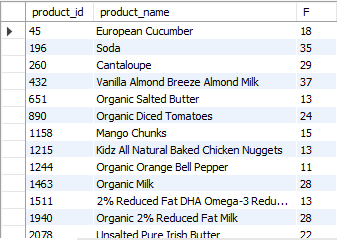

* 어떤 상품들이 재구매율이 높은지 보기 위해 ptoducts테이블을 join하여 살펴본다.

In [ ]:
# 어떤 상품들이 재구매율이 높은지 보기 위해 ptoducts테이블 join
SELECT A.product_id, B.product_name,
SUM(reordered)/SUM(1) Reorder_Rate,
COUNT(DISTINCT order_id) F
FROM order_products__prior A
LEFT JOIN products B
ON A.product_id = B.product_id
GROUP BY product_id, product_name
HAVING COUNT(DISTINCT order_id) > 10;

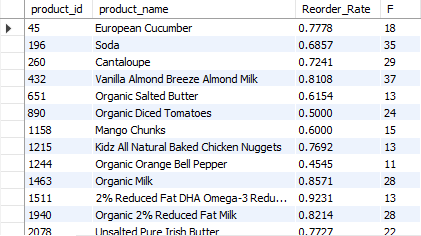

## 다음 구매까지의 소요 기간과 재구매 관계

* 재구매율이 높은 순서대로 상품을 10가지 그룹으로 구분하고, 각 그룹에서의 구매 소요 기간의 분산을 구해보고자 한다.
* 다음과 같은 방법으로 상품별 재구매율을 계산하고, 가장 높은 순위를 매긴다.

In [ ]:
# 상품별 재구매율을 계산하고, 가장 높은 순위를 매긴다
SELECT *
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY Ret_Ratio DESC) RNK
FROM
(SELECT product_id,
SUM(CASE WHEN reordered = 1 THEN 1 ELSE 0 END)/COUNT(*) Ret_Ratio
FROM order_products__prior
GROUP BY 1) A) A;

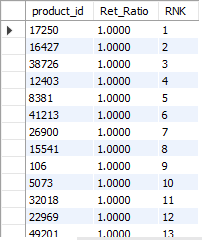

* 10분위 분석과 동일한 방법으로 각 상품을 10개의 그룹으로 나눈다.

In [ ]:
# 10분위 분석과 동일한 방법으로 각 상품을 10개의 그룹으로 나눈다
CREATE TEMPORARY TABLE product_repurchase_quantile AS
SELECT A.product_id,
CASE WHEN RNK <= 929 THEN 'Q_1'
WHEN RNK <= 1858 THEN 'Q_2'
WHEN RNK <= 2786 THEN 'Q_3'
WHEN RNK <= 3715 THEN 'Q_4'
WHEN RNK <= 4644 THEN 'Q_5'
WHEN RNK <= 5573 THEN 'Q_6'
WHEN RNK <= 6502 THEN 'Q_7'
WHEN RNK <= 7430 THEN 'Q_8'
WHEN RNK <= 8359 THEN 'Q_9'
WHEN RNK <= 9288 THEN 'Q_10' END RNK_GRP
FROM
(SELECT *,
ROW_NUMBER() OVER(ORDER BY Ret_Ratio DESC) RNK
FROM
(SELECT product_id,
SUM(CASE WHEN reordered = 1 THEN 1 ELSE 0 END)/COUNT(*) Ret_Ratio
FROM order_products__prior
GROUP BY 1) A) A
GROUP BY 1, 2;

In [ ]:
# 생성한 테이블 확인
SELECT * FROM product_repurchase_quantile;

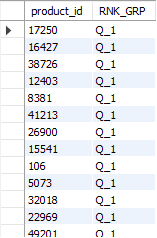

* 위의 쿼리로 product_id별 분위 수를 계산할 수 있고 계산된 상품별 분위 수는 product_repurchase_quantile테이블에 생성된다.
* 이제 각 분위 수별로 재구매 소요 시간의 분산을 구한다.

* 먼저 order_products__prior에 orders테이블을 결합해 days_since_prior_order를 구한다.

In [ ]:
# order_products__prior에 orders테이블 결합
CREATE TEMPORARY TABLE order_products__prior2 AS
SELECT product_id, days_since_prior_order
FROM order_products__prior A
INNER JOIN orders B
ON A.order_id = B.order_id;

* 다음으로 결합한 테이블에서 분위수, 상품별 구매 소요 기간의 분산을 계산한다.

In [ ]:
# 결합한 테이블에서 분위수, 상품별 구매 소요 기간의 분산 계산
SELECT A.RNK_GRP, A.product_id,
VARIANCE(days_since_prior_order) Var_Days
FROM product_repurchase_quantile A
LEFT JOIN order_products__prior2 B
ON A.product_id = B.product_id
GROUP BY 1, 2
ORDER BY 1;

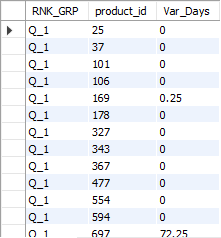

* 각 분위 수의 상품 소요 기간 분산의 중위 수를 계산한다. 계산한 결과를 보고 분위 수별 구매 소요 기간에 차이가 존재하는지 확인할 수 있다.
* MySQL에서는 Median함수를 제공X -> avg()함수를 이용해 평균으로 대체

In [ ]:
# 각 분위 수의 상품 소요 기간 분산의 중위 수를 계산
SELECT RNK_GRP,
AVG(Var_Days) AVG_Var_Days
FROM
(SELECT A.RNK_GRP, A.product_id,
VARIANCE(days_since_prior_order) Var_Days
FROM product_repurchase_quantile A
LEFT JOIN order_products__prior B
ON A.product_id = B.product_id
LEFT JOIN orders C
ON B.order_id = C.order_id
GROUP BY 1, 2) A
GROUP BY 1
ORDER BY 1;

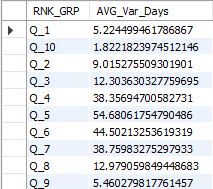